Пояснения:

Предобработка данных: Удалены пропуски и пользователи, попавшие в обе группы.
Первичный анализ: Рассчитаны ключевые метрики (посещения, покупки, конверсия, среднее рекламы).
Статистические тесты:
    Z-тест для сравнения конверсий.
    T-тест для сравнения среднего количества рекламы.
Доверительные интервалы: Построены для конверсий и средних значений.

Пропуски в данных:
user id          0
test group       0
converted        0
total ads        0
most ads day     0
most ads hour    0
dtype: int64

Сводные показатели:
              Группа  Посещения  Покупки  Конверсия (%)  \
0  Контрольная (PSA)     582481      420       1.785411   
0      Тестовая (Ad)   14014701    14423       2.554656   

   Среднее количество рекламы  
0                   24.761138  
0                   24.823365  

Z-тест для конверсий: p-значение = 0.0000
T-тест для среднего количества рекламы: p-значение = 0.8274

Доверительные интервалы (95%):
Конверсия (PSA): (np.float64(0.01616179166954737), np.float64(0.01954642121941709))
Конверсия (Ad): (np.float64(0.025134998295895647), np.float64(0.025958120977471848))
Разница конверсий: p-значение = 0.0000
Среднее рекламы (PSA): (np.float64(24.2133977421175), np.float64(25.308877381160855))
Среднее рекламы (Ad): (np.float64(24.709242934208064), np.float64(24.93748727265477))


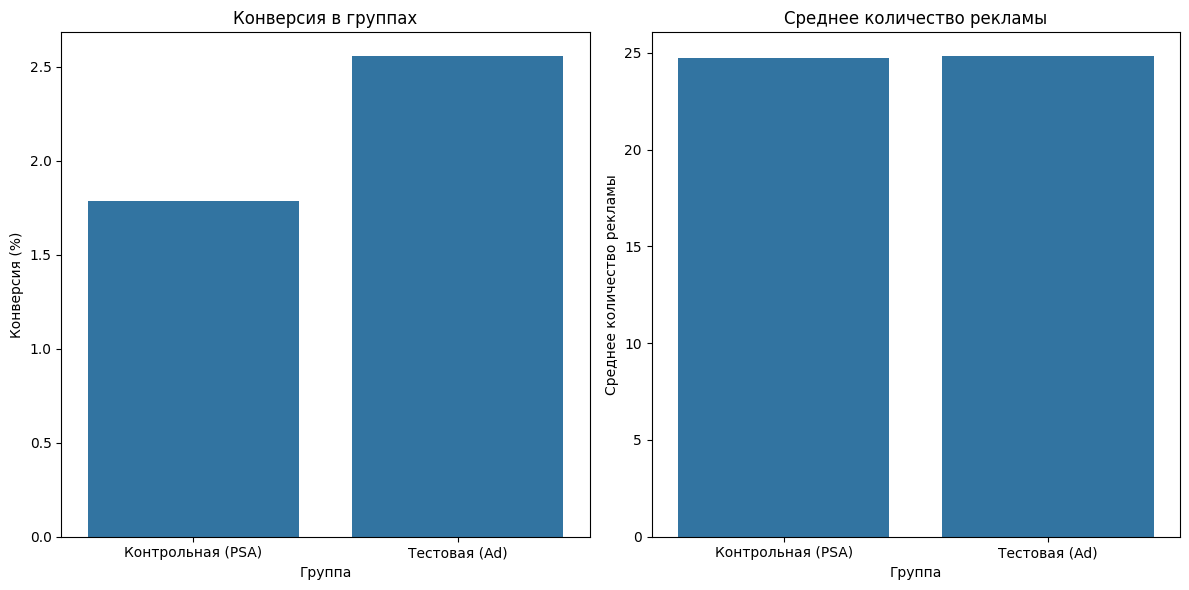

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных
df = pd.read_csv('marketing_AB.csv')

# Предобработка данных
# Удаление ненужного столбца с индексом
df = df.drop(columns=['Unnamed: 0'])

# Преобразование типов данных
df['converted'] = df['converted'].astype(int)  # True/False в 1/0

# Проверка на пропуски
print("Пропуски в данных:")
print(df.isnull().sum())

# Удаление строк с пропусками (если есть)
df = df.dropna()

# Проверка пользователей в обеих группах
duplicate_users = df.groupby('user id')['test group'].nunique()
duplicate_users = duplicate_users[duplicate_users > 1].index.tolist()
df = df[~df['user id'].isin(duplicate_users)]

# Разделение на группы
control_group = df[df['test group'] == 'psa']
test_group = df[df['test group'] == 'ad']

# Первичный анализ
def calculate_metrics(group, name):
    visits = group['total ads'].sum()
    purchases = group['converted'].sum()
    conversion_rate = purchases / len(group)
    avg_ads = group['total ads'].mean()
    return pd.DataFrame({
        'Группа': [name],
        'Посещения': [visits],
        'Покупки': [purchases],
        'Конверсия (%)': [conversion_rate * 100],
        'Среднее количество рекламы': [avg_ads]
    })

results = pd.concat([
    calculate_metrics(control_group, 'Контрольная (PSA)'),
    calculate_metrics(test_group, 'Тестовая (Ad)')
])

print("\nСводные показатели:")
print(results)

# Статистический анализ
# Проверка разницы конверсий (Z-тест)
from statsmodels.stats.proportion import proportions_ztest

count = [test_group['converted'].sum(), control_group['converted'].sum()]
nobs = [len(test_group), len(control_group)]
z_stat, p_val = proportions_ztest(count, nobs)
print(f"\nZ-тест для конверсий: p-значение = {p_val:.4f}")

# Проверка разницы среднего количества рекламы (T-тест)
t_stat, p_val_ads = stats.ttest_ind(
    test_group['total ads'], control_group['total ads'], equal_var=False
)
print(f"T-тест для среднего количества рекламы: p-значение = {p_val_ads:.4f}")

# Доверительные интервалы (95%)
def get_confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    sem = stats.sem(data)
    ci = stats.t.interval(confidence, len(data)-1, loc=mean, scale=sem)
    return ci

# Конверсии
ci_conv_control = get_confidence_interval(control_group['converted'])
ci_conv_test = get_confidence_interval(test_group['converted'])

# Разница конверсий
diff_conv = test_group['converted'].mean() - control_group['converted'].mean()
ci_diff_conv = proportions_ztest(count, nobs, value=0)[1]

# Среднее количество рекламы
ci_ads_control = get_confidence_interval(control_group['total ads'])
ci_ads_test = get_confidence_interval(test_group['total ads'])

print("\nДоверительные интервалы (95%):")
print(f"Конверсия (PSA): {ci_conv_control}")
print(f"Конверсия (Ad): {ci_conv_test}")
print(f"Разница конверсий: p-значение = {ci_diff_conv:.4f}")
print(f"Среднее рекламы (PSA): {ci_ads_control}")
print(f"Среднее рекламы (Ad): {ci_ads_test}")

# Визуализация
plt.figure(figsize=(12, 6))

# Конверсии
plt.subplot(1, 2, 1)
sns.barplot(x='Группа', y='Конверсия (%)', data=results)
plt.title('Конверсия в группах')

# Среднее количество рекламы
plt.subplot(1, 2, 2)
sns.barplot(x='Группа', y='Среднее количество рекламы', data=results)
plt.title('Среднее количество рекламы')
plt.tight_layout()
plt.show()

Выводы:
Если p-значение < 0.05, различия статистически значимы.
Перекрытие доверительных интервалов указывает на возможное отсутствие значимых различий.